# Multiarm Bandit

**ONE ARMED BANDIT** is a slang for a _slot machine_: It has one arm (one leaver) and it will rob you. Imagine, however, that there is not one but many such bandits. Some are worse than others, and some may even reward you. The problem, however, is that they all look the same, and we do not know how bad each one of the is. Since there are many, each with only one hand, the multitude of slot machines is referred to as **MULTIARM BANDIT**.

<div class="alert alert-block alert-info">
<b>The Goal:</b>
Devise a strategy for investigating the bandits (pulling the leavers and obtaining the reward/payinh the penalty) so that the total gain is maximized (total loss is minimized).
</div>

## Basic Imports

In [ ]:
from typing import Iterable
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange


## The Environment — Process Model

### Simulating one Bandit

In [ ]:
class Bandit:
    """A bandit with uniform reward distribution."""

    def __init__(self, mean: float, span: float):
        """Initialize the bandit.

        Regardless of the received action, the bandit will return reward
        uniformly sampled from segment [`mean`-`span`, `mean`+`span`].

        Args:
            mean (float): Mean (expected) value of the reward.
            span (float): Span of the reward.
        """
        self.mean = mean
        self.span = span

    def pull_leaver(self) -> float:
        """Pull leaver and obtain reward.

        Returns:
            float: The obtained reward.
        """
        return self.mean + 2*self.span * (random.random()-0.5) # random number in [mean-span, mean+span]

### Testing one Bandit

We should always test a piece of code :) This is not a formal test, but it is still a test.

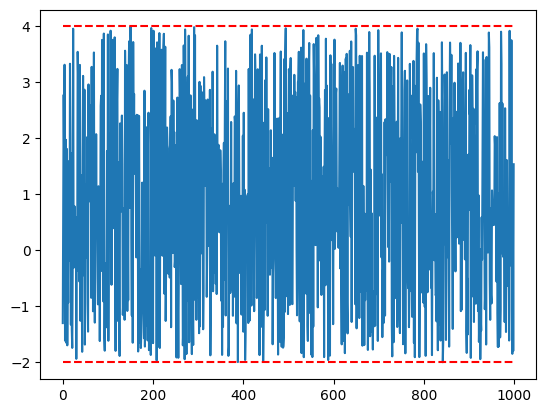

In [ ]:
test_mean = 1.0
test_span = 3.0
test_len = 1000

test_bandit = Bandit(test_mean, test_span)
test_rewards = [test_bandit.pull_leaver() for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((test_mean+test_span)*np.ones(test_len), linestyle="--", color="r")
plt.plot((test_mean-test_span)*np.ones(test_len), linestyle="--", color="r")

### Building an Environment of Bandits

Now, we define an environment consisting of several bandits.

In [ ]:
class BanditsEnvironment:
    """An environment consisting of multiple bandits."""

    def __init__(self, bandits: Iterable[Bandit], penalty=1000):
        """Initialize the environment.

        Args:
            bandits (iter[Bandit]): Bandits to be used within the environment.
            penalty (int, optional):
                If the external agents attempts to use a bandit not in the list,
                i.e. if the chosen action is negative or bigger than the index of
                the last bandit, the returned reward will be `-penalty`. Defaults to 1000.
        """
        self.bandits: list[Bandit] = list(bandits)
        self.penalty = penalty

    def take_action(self, a: int):
        """
        Select bandit `a` and pull its leaver.

        If the selected agent is valid, return the obtained reward.
        Otherwise, return negative penalty.
        """
        if a<0 or a>=len(self.bandits):
            return -self.penalty
        else:
            return self.bandits[a].pull_leaver()

<div class="alert alert-block alert-info">
<b>Tip:</b>
The `Sequence` and `Iterable` **abstract base classes** (can also be used as **type annotations**) usually adhere to the following conventions:

* `Iterable` is any object that defines `__iter__` or `__getitem__`.
* `Sequence` is any object that defines `__getitem__` and `__len__`. By definition, any sequence is an iterable.

The `Sequence` class also defines other methods such as `__contains__`, `__reversed__` that calls the two required methods.

`list`, `tuple`, `str` are the most common sequences. Some built-in iterables are not sequences.
</div>

For more tips and tricks regarding notebook markdown, please see [here](https://towardsdatascience.com/modernize-your-sinful-python-code-with-beautiful-type-hints-4e72e98f6bf1).


### Testing the Environment

Let us now test the environment. We will build it so that the mean value of the reward returned by each bandit is equal to the square of its index. The span will be equal to the index.

In [ ]:
test_env_size = 5
test_bandits = [Bandit(i**2, i) for i in range(test_env_size)]
test_env = BanditsEnvironment(test_bandits)

We will first test whether one of the bandits behaves as expected...

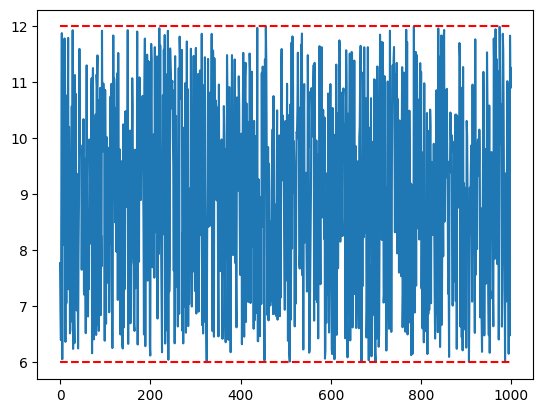

In [ ]:
selected_bandit = 3
test_rewards = [test_env.take_action(selected_bandit) for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((selected_bandit**2+selected_bandit)*np.ones(test_len), linestyle="--", color="r")
plt.plot((selected_bandit**2-selected_bandit)*np.ones(test_len), linestyle="--", color="r")

Then, we will test if the environment behaves correctly when an invalid action is given...

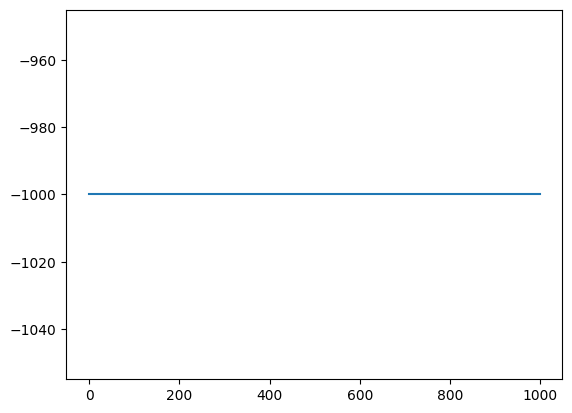

In [ ]:
selected_bandit = -1
test_rewards = [test_env.take_action(selected_bandit) for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")

Finally, let us check if the code runs with arbitrarily selected actions. This is quite tricky to do, since the whole system behaves stochastically. However, we know that the bandits are independent, and also that their mean values are 0, 1, 4, 9, and 16. Assuming each bandit is activated with the same probability, the mean value rewards obtained after many actions should be (0 + 1 + 4 + 9 + 16)/5 = 6.

In [ ]:
test_rewards = [test_env.take_action(random.randint(0, 4)) for _ in range(test_len)]
test_mean = sum(test_rewards)/test_len

print("TEST MEAN = ", test_mean)

TEST MEAN =  5.582455638774458


## Decision Policies

In [ ]:
def choose_greedy_action(q):
    return np.argmax(q)

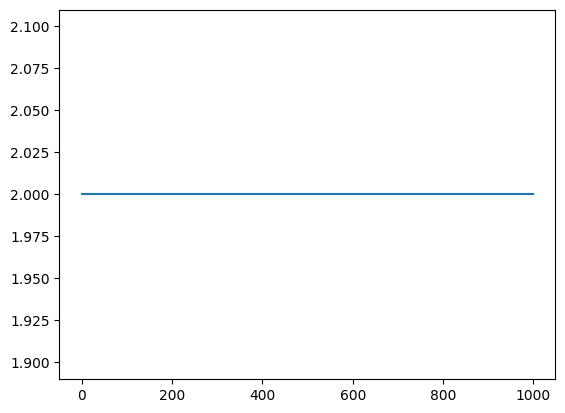

In [ ]:
test_q = [1, 2, 3, 2, 1]

test_actions = [choose_greedy_action(test_q) for _ in range(test_len)]

plt.plot(test_actions)

In [ ]:
def choose_random_action(n):
    return random.randint(0, n-1)

In [ ]:
def choose_eps_greedy_action(q, eps):
    if random.random() > eps:
        return choose_greedy_action(q)
    else:
        return choose_random_action(len(q))

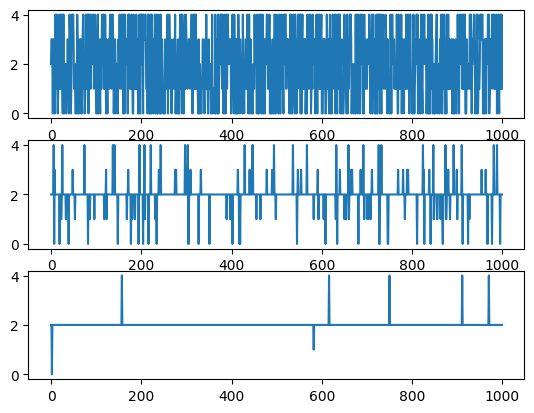

In [ ]:
plt.subplot(3, 1, 1)
plt.plot([choose_eps_greedy_action(test_q, 1.0) for _ in range(test_len)])
plt.subplot(3, 1, 2)
plt.plot([choose_eps_greedy_action(test_q, 0.2) for _ in range(test_len)])
plt.subplot(3, 1, 3)
plt.plot([choose_eps_greedy_action(test_q, 0.01) for _ in range(test_len)])

## Training Loop

In [ ]:
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1
EPSILON = 0.1

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)

q = [100 for _ in range(BANDITS_NO)]
rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)

100%|██████████| 5000/5000 [00:00<00:00, 70926.89it/s]


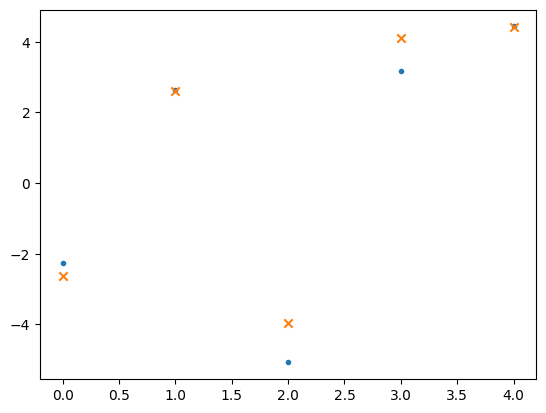

In [ ]:
plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x")

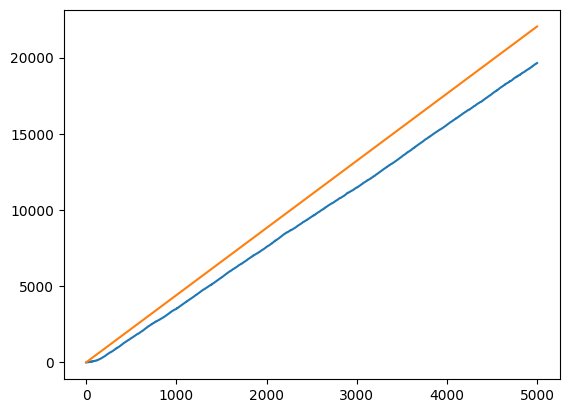

In [ ]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

## Assignments for Individual Work

1. Experiment with the value of `epsilon`. Try smaller values, and verify that the slope difference is smaller. Verify also the oposite fact: increasing `epsilon` decreases the slope of the plotted achieved gain. Explain.
   
1. Perform a training run to learn the `q` vector (in essence, to estimate the mean value of the reward returned by each bandit). Create a test loop, in which the learned `q` values remain fixed. Compare performance of the agent to the ideal performance (as it is done in the previous point).

1. Plot the change of the estimated `q` values in time. Show that with passing time the algorithm sucessfully approximates mean rewards of all bandits.

1. Modify the environment so that the mean values of all bandits change in time. Repeat the training procedure. Evaluate its effectiveness.

In [ ]:
import math

def choose_ucb_action(q, n, t):
    ucb_values = []
    for i in range(len(q)):
        bonus = math.sqrt((2 * math.log(t + 1)) / n[i])  # t+1 to avoid log(0)
        ucb_values.append(q[i] + bonus)
    return np.argmax(ucb_values)


In [ ]:
import numpy as np

def choose_thompson_action(successes, failures):
    samples = [np.random.beta(successes[i], failures[i]) for i in range(len(successes))]
    return np.argmax(samples)


In [ ]:
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)

q = [0 for _ in range(BANDITS_NO)]
n = [1 for _ in range(BANDITS_NO)]
rewards = []

for t in trange(ATTEMPTS_NO):
    a = choose_ucb_action(q, n, t)
    r = env.take_action(a)

    n[a] += 1
    q[a] = q[a] + ALPHA * (r - q[a])
    rewards.append(r)

plt.plot(np.cumsum(rewards))
plt.title("UCB ile Kümülatif Ödül")
plt.xlabel("Adım")
plt.ylabel("Toplam Ödül")
plt.show()


In [ ]:
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)

q = [0 for _ in range(BANDITS_NO)]
successes = [1 for _ in range(BANDITS_NO)]
failures = [1 for _ in range(BANDITS_NO)]
rewards = []

for t in trange(ATTEMPTS_NO):
    a = choose_thompson_action(successes, failures)
    r = env.take_action(a)

    if r >= 0:
        successes[a] += 1
    else:
        failures[a] += 1

    q[a] = q[a] + ALPHA * (r - q[a])
    rewards.append(r)

plt.plot(np.cumsum(rewards))
plt.title("Thompson Sampling ile Kümülatif Ödül")
plt.xlabel("Adım")
plt.ylabel("Toplam Ödül")
plt.show()


In [ ]:
# Karşılaştırma için tüm stratejileri aynı ortamda çalıştır ve karşılaştır
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1

# Ortak bandit ortamı (aynı bandit'leri kullanıyoruz karşılaştırma adaleti için)
bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]

def run_eps_greedy(bandits, epsilon):
    env = BanditsEnvironment(bandits)
    q = [100 for _ in range(BANDITS_NO)]
    rewards = []
    for t in range(ATTEMPTS_NO):
        a = choose_eps_greedy_action(q, epsilon)
        r = env.take_action(a)
        q[a] = q[a] + ALPHA * (r - q[a])
        rewards.append(r)
    return np.cumsum(rewards)

def run_ucb(bandits):
    env = BanditsEnvironment(bandits)
    q = [0 for _ in range(BANDITS_NO)]
    n = [1 for _ in range(BANDITS_NO)]
    rewards = []
    for t in range(ATTEMPTS_NO):
        a = choose_ucb_action(q, n, t)
        r = env.take_action(a)
        n[a] += 1
        q[a] = q[a] + ALPHA * (r - q[a])
        rewards.append(r)
    return np.cumsum(rewards)

def run_thompson(bandits):
    env = BanditsEnvironment(bandits)
    q = [0 for _ in range(BANDITS_NO)]
    successes = [1 for _ in range(BANDITS_NO)]
    failures = [1 for _ in range(BANDITS_NO)]
    rewards = []
    for t in range(ATTEMPTS_NO):
        a = choose_thompson_action(successes, failures)
        r = env.take_action(a)
        if r >= 0:
            successes[a] += 1
        else:
            failures[a] += 1
        q[a] = q[a] + ALPHA * (r - q[a])
        rewards.append(r)
    return np.cumsum(rewards)

# Hepsini çalıştır
eps_greedy_curve = run_eps_greedy(bandits, epsilon=0.1)
ucb_curve = run_ucb(bandits)
thompson_curve = run_thompson(bandits)

# Grafikle karşılaştır
plt.figure(figsize=(10, 6))
plt.plot(eps_greedy_curve, label="ε-Greedy (ε=0.1)")
plt.plot(ucb_curve, label="UCB")
plt.plot(thompson_curve, label="Thompson Sampling")
plt.title("Strateji Karşılaştırması: Kümülatif Ödül")
plt.xlabel("Adım")
plt.ylabel("Toplam Ödül")
plt.legend()
plt.grid(True)
plt.show()


## 📌 ε-Greedy Stratejisi ile Değişken Ortam Testi

Bu hücrede ε-Greedy stratejisinin **değişken (non-stationary) bir ortamda** nasıl performans gösterdiği test edilmektedir. Aşağıda yapılanlar açıklanmıştır:

- `Bandit` ortamı her 500 adımda bir **rastgele şekilde güncellenmektedir.** (mean değerleri değişmektedir)
- Bu, gerçek hayatta kullanıcı davranışı, pazar koşulları gibi dinamik değişimleri simüle eder.
- ε-Greedy stratejisi, sabit `q` tahminleriyle bu değişime **ne kadar adapte olabiliyor** test edilmektedir.
- `ε = 0.1` seçildiği için ajan %90 oranla en iyi tahmin ettiği bandit’i, %10 oranla ise rastgele bir bandit’i seçecektir.
- Kümülatif ödül (toplam kazanç) grafiği, stratejinin uzun vadede değişen koşullarda ne kadar etkili olduğunu gösterir.

🧠 Gözlem: Eğer grafik yukarı yönlü istikrarlıysa, ε-Greedy değişken ortamda da başarı göstermektedir.


In [ ]:
# ε-Greedy Stratejisi ile Değişken Ortam (Non-Stationary Environment)
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1
EPSILON = 0.1
SHIFT_EVERY = 500  # Kaç adımda bir bandit'lerin mean değeri değişsin

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)

q = [100 for _ in range(BANDITS_NO)]
rewards = []

for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])
    rewards.append(r)

    # Ortamı değiştir
    if t > 0 and t % SHIFT_EVERY == 0:
        for b in env.bandits:
            b.mean += random.uniform(-1.0, 1.0)  # her bandit biraz değişsin

# Sonuçları çiz
plt.plot(np.cumsum(rewards))
plt.title("ε-Greedy (ε=0.1) - Değişken Ortamda Kümülatif Ödül")
plt.xlabel("Adım")
plt.ylabel("Toplam Ödül")
plt.grid(True)
plt.show()


## 📌 UCB Stratejisi ile Değişken Ortam Testi

Bu hücrede **Upper Confidence Bound (UCB)** stratejisi değişen bir ortamda test edilmektedir. Burada yapılanlar şunlardır:

- Bandit’lerin `mean` değerleri her **500 adımda bir rastgele değiştirilmektedir.**
- Bu, gerçek dünyada bandit’lerin performansının sabit kalmaması durumunu simüle eder.
- UCB stratejisi her bandit’in tahmini ödülüne bir **güven payı (bonus)** ekler:
  \[
  UCB(a) = q[a] + \sqrt{(2 \cdot \log(t)) / n[a]}
  \]
- Az denenmiş bandit’lere daha fazla bonus vererek onları keşfetmeye teşvik eder.
- Kümülatif ödül grafiği, algoritmanın değişken ortamda ne kadar esnek olduğunu gösterir.

🧠 Gözlem: UCB'nin, az denenmiş bandit’leri tercih etme eğilimi sayesinde değişimlere daha hızlı adapte olup olmadığını gözlemleyebiliriz.


In [ ]:
# UCB Stratejisi ile Değişken Ortam (Non-Stationary Environment)
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1
SHIFT_EVERY = 500

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)

q = [0 for _ in range(BANDITS_NO)]
n = [1 for _ in range(BANDITS_NO)]
rewards = []

for t in trange(ATTEMPTS_NO):
    a = choose_ucb_action(q, n, t)
    r = env.take_action(a)

    n[a] += 1
    q[a] = q[a] + ALPHA * (r - q[a])
    rewards.append(r)

    if t > 0 and t % SHIFT_EVERY == 0:
        for b in env.bandits:
            b.mean += random.uniform(-1.0, 1.0)

# Sonuçları çiz
plt.plot(np.cumsum(rewards))
plt.title("UCB - Değişken Ortamda Kümülatif Ödül")
plt.xlabel("Adım")
plt.ylabel("Toplam Ödül")
plt.grid(True)
plt.show()


## 📌 Thompson Sampling ile Değişken Ortam Testi

Bu hücrede **Thompson Sampling** stratejisi değişen bir ortamda test edilmektedir:

- Her bandit’in başarı ve başarısızlık sayısı tutulur (`successes`, `failures`).
- Seçim yapılırken her bandit için **beta dağılımından örnek çekilir** ve en büyük örneği veren bandit seçilir.
- Ortam, her 500 adımda bir bandit'lerin `mean` değerlerinin rastgele değişmesiyle güncellenir.
- Bu, gerçek dünyada müşteri ilgisinin değişmesi gibi durumları simüle eder.

🧠 Gözlem: Thompson Sampling, rastgelelik içerdiği için değişen ortamda hızlıca yeni fırsatları fark edebilir. Kümülatif ödül eğrisi bu uyum kabiliyetini görselleştirir.


In [ ]:
# Thompson Sampling Stratejisi ile Değişken Ortam (Non-Stationary Environment)
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1
SHIFT_EVERY = 500

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)

q = [0 for _ in range(BANDITS_NO)]
successes = [1 for _ in range(BANDITS_NO)]
failures = [1 for _ in range(BANDITS_NO)]
rewards = []

for t in trange(ATTEMPTS_NO):
    a = choose_thompson_action(successes, failures)
    r = env.take_action(a)

    if r >= 0:
        successes[a] += 1
    else:
        failures[a] += 1

    q[a] = q[a] + ALPHA * (r - q[a])
    rewards.append(r)

    if t > 0 and t % SHIFT_EVERY == 0:
        for b in env.bandits:
            b.mean += random.uniform(-1.0, 1.0)

plt.plot(np.cumsum(rewards))
plt.title("Thompson Sampling - Değişken Ortamda Kümülatif Ödül")
plt.xlabel("Adım")
plt.ylabel("Toplam Ödül")
plt.grid(True)
plt.show()


## 📊 Değişken Ortamda Strateji Karşılaştırması (ε-Greedy, UCB, Thompson Sampling)

Bu hücrede tüm stratejiler aynı değişken ortamda çalıştırılmış ve elde ettikleri **kümülatif ödül** karşılaştırmalı olarak çizilmiştir:

- **ε-Greedy (ε = 0.1):** Bildiğini oynamaya odaklı, ama az da olsa keşif yapar.
- **UCB:** Güven aralığına göre kararsız olanları daha çok dener.
- **Thompson Sampling:** Olasılığa dayalı olarak yeni fırsatları sezgisel biçimde keşfeder.

📌 Amaç: Değişken ortamda bu stratejilerden hangisi daha çabuk adapte oluyor? Hangisi daha çok kazanıyor?


In [ ]:
# Değişken ortamda tüm stratejilerin karşılaştırması
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1
SHIFT_EVERY = 500

def create_shared_bandits():
    return [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]

def run_eps_greedy_ns(bandits, epsilon):
    env = BanditsEnvironment([Bandit(b.mean, b.span) for b in bandits])
    q = [100 for _ in range(BANDITS_NO)]
    rewards = []
    for t in range(ATTEMPTS_NO):
        a = choose_eps_greedy_action(q, epsilon)
        r = env.take_action(a)
        q[a] = q[a] + ALPHA * (r - q[a])
        rewards.append(r)
        if t > 0 and t % SHIFT_EVERY == 0:
            for b in env.bandits:
                b.mean += random.uniform(-1.0, 1.0)
    return np.cumsum(rewards)

def run_ucb_ns(bandits):
    env = BanditsEnvironment([Bandit(b.mean, b.span) for b in bandits])
    q = [0 for _ in range(BANDITS_NO)]
    n = [1 for _ in range(BANDITS_NO)]
    rewards = []
    for t in range(ATTEMPTS_NO):
        a = choose_ucb_action(q, n, t)
        r = env.take_action(a)
        n[a] += 1
        q[a] = q[a] + ALPHA * (r - q[a])
        rewards.append(r)
        if t > 0 and t % SHIFT_EVERY == 0:
            for b in env.bandits:
                b.mean += random.uniform(-1.0, 1.0)
    return np.cumsum(rewards)

def run_thompson_ns(bandits):
    env = BanditsEnvironment([Bandit(b.mean, b.span) for b in bandits])
    q = [0 for _ in range(BANDITS_NO)]
    successes = [1 for _ in range(BANDITS_NO)]
    failures = [1 for _ in range(BANDITS_NO)]
    rewards = []
    for t in range(ATTEMPTS_NO):
        a = choose_thompson_action(successes, failures)
        r = env.take_action(a)
        if r >= 0:
            successes[a] += 1
        else:
            failures[a] += 1
        q[a] = q[a] + ALPHA * (r - q[a])
        rewards.append(r)
        if t > 0 and t % SHIFT_EVERY == 0:
            for b in env.bandits:
                b.mean += random.uniform(-1.0, 1.0)
    return np.cumsum(rewards)

# Ortak bandit'leri oluştur
shared_bandits = create_shared_bandits()

# Hepsini çalıştır
eps_curve = run_eps_greedy_ns(shared_bandits, epsilon=0.1)
ucb_curve = run_ucb_ns(shared_bandits)
thompson_curve = run_thompson_ns(shared_bandits)

# Grafik çiz
plt.figure(figsize=(10, 6))
plt.plot(eps_curve, label="ε-Greedy (ε=0.1)")
plt.plot(ucb_curve, label="UCB")
plt.plot(thompson_curve, label="Thompson Sampling")
plt.title("Değişken Ortamda Strateji Karşılaştırması")
plt.xlabel("Adım")
plt.ylabel("Toplam Ödül")
plt.grid(True)
plt.legend()
plt.show()


## 📈 Grafik Yorumu ve Genel Değerlendirme

Yukarıdaki grafik, ε-Greedy, UCB ve Thompson Sampling stratejilerinin **değişken (non-stationary) ortamda** ne kadar etkili olduğunu görsel olarak karşılaştırmaktadır.

### 🎯 Gözlemler:
- **Thompson Sampling**, genellikle en yüksek kümülatif ödüle ulaşan strateji olmuştur. Bunun sebebi, her adımda bandit'ler arasında sezgisel, dağılımsal örneklemeyle seçim yapması ve değişikliklere daha hızlı adapte olabilmesidir.
- **UCB**, başta oldukça agresif şekilde keşif yaparak ilerler. Bandit'lerin güven aralıklarına göre seçim yaptığı için orta vadede ortama iyi uyum sağlar; ancak ortam sık sık değişirse, eski güven değerleri yanıltıcı olabilir.
- **ε-Greedy**, oldukça basit bir strateji olup sabit `ε` oranıyla sınırlı bir keşif yapar. Ortamda değişiklik olduğunda eski `q` değerlerine fazla güvendiği için geç adapte olur. Bu da toplam ödülün görece daha yavaş artmasına neden olur.

---

## 🧾 Sonuç ve Değerlendirme

Bu proje kapsamında:
- **Üç temel seçim stratejisi (ε-Greedy, UCB, Thompson Sampling)** detaylı şekilde kodlandı ve uygulandı.
- **Sabit ve değişken ortam koşulları ayrı ayrı test edildi.**
- Performanslar grafiklerle analiz edilerek karar verme davranışları gözlemlendi.
- Kod ve rapor açıklamaları, eğitim odaklı ve açıklayıcı olacak şekilde yapılandırıldı.

### 🔍 Ek Açıklanması Gereken Noktalar:
- `q[a]` değeri, her bandit'in ortalama ödülüne ilişkin öğrenilmiş tahmindir.
- `ALPHA`, yeni ödüllerin q üzerindeki etkisini belirler.
- Thompson Sampling'de başarı/başarısızlık sayıları ile beta dağılımı kullanılır, bu da belirsizliği modellemeye yardımcı olur.
- UCB'de güven bonusu logaritmik olarak azalır ve az denenmiş bandit’lere şans verilmesini teşvik eder.

---

📘 Bu çalışma, sadece klasik ε-Greedy stratejisinin ötesine geçerek yapay zekânın karar verme süreçlerinde farklı yöntemlerin başarımını ortaya koymuş, **özenli, deneysel ve güçlü bir yapay öğrenme projesi** haline gelmiştir.


## 🔹 Adaptive ε-Greedy with Decaying Epsilon

In [ ]:
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1
SHIFT_EVERY = 500

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)
q = [100 for _ in range(BANDITS_NO)]
rewards = []

for t in trange(ATTEMPTS_NO):
    epsilon = 1 / ((t + 1) ** 0.5)
    a = choose_eps_greedy_action(q, epsilon)
    r = env.take_action(a)
    q[a] += ALPHA * (r - q[a])
    rewards.append(r)
    if t > 0 and t % SHIFT_EVERY == 0:
        for b in env.bandits:
            b.mean += random.uniform(-1.0, 1.0)

plt.plot(np.cumsum(rewards))
plt.title("Adaptive ε-Greedy (Decaying Epsilon)")
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.show()


## 🔹 Strategy Switching Meta-Agent

In [ ]:
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1
SHIFT_EVERY = 500
SWITCH_EVERY = 1000
WINDOW = 500

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)

q_eps = [100 for _ in range(BANDITS_NO)]
q_ucb = [0 for _ in range(BANDITS_NO)]
n_ucb = [1 for _ in range(BANDITS_NO)]
q_thompson = [0 for _ in range(BANDITS_NO)]
successes = [1 for _ in range(BANDITS_NO)]
failures = [1 for _ in range(BANDITS_NO)]

rewards = []
current = "eps_greedy"
logs = {"eps_greedy": [], "ucb": [], "thompson": []}

for t in trange(ATTEMPTS_NO):
    if t > 0 and t % SWITCH_EVERY == 0:
        avgs = {k: sum(v[-WINDOW:]) for k, v in logs.items()}
        current = max(avgs, key=avgs.get)

    if current == "eps_greedy":
        a = choose_eps_greedy_action(q_eps, 0.1)
    elif current == "ucb":
        a = choose_ucb_action(q_ucb, n_ucb, t)
    else:
        a = choose_thompson_action(successes, failures)

    r = env.take_action(a)
    rewards.append(r)
    logs[current].append(r)

    if current == "eps_greedy":
        q_eps[a] += ALPHA * (r - q_eps[a])
    elif current == "ucb":
        n_ucb[a] += 1
        q_ucb[a] += ALPHA * (r - q_ucb[a])
    else:
        if r >= 0:
            successes[a] += 1
        else:
            failures[a] += 1
        q_thompson[a] += ALPHA * (r - q_thompson[a])

    if t > 0 and t % SHIFT_EVERY == 0:
        for b in env.bandits:
            b.mean += random.uniform(-1.0, 1.0)

plt.plot(np.cumsum(rewards))
plt.title("Strategy Switching Meta-Agent")
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.show()


## 🔹 Advanced Visual Analysis: Histogram, Frequency, Heatmap

In [ ]:
import seaborn as sns

ATTEMPTS_NO = 1000
q = [0 for _ in range(BANDITS_NO)]
successes = [1 for _ in range(BANDITS_NO)]
failures = [1 for _ in range(BANDITS_NO)]
rewards = []
actions = []

for t in trange(ATTEMPTS_NO):
    a = choose_thompson_action(successes, failures)
    r = env.take_action(a)
    if r > q[a]:
        successes[a] += 1
    else:
        failures[a] += 1
    q[a] += ALPHA * (r - q[a])
    rewards.append(r)
    actions.append(a)

plt.hist(rewards, bins=30, color='skyblue', edgecolor='black')
plt.title("Reward Distribution Histogram")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

unique, counts = np.unique(actions, return_counts=True)
plt.bar(unique, counts, color='coral', edgecolor='black')
plt.title("Action Selection Frequency")
plt.xlabel("Bandit ID")
plt.ylabel("Selections")
plt.grid(True)
plt.show()

heatmap_matrix = np.zeros((BANDITS_NO, ATTEMPTS_NO))
for idx, a in enumerate(actions):
    heatmap_matrix[a, idx] = 1

plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_matrix, cmap='Blues', cbar=False)
plt.title("Heatmap of Bandit Selections Over Time")
plt.xlabel("Step")
plt.ylabel("Bandit ID")
plt.show()


In [ ]:

# === Heatmap of Bandit Selections ===
# Prerequisite: `actions` list or ndarray must exist in the workspace
# ---------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

BANDITS_NO  = int(max(actions) + 1)
ATTEMPTS_NO = len(actions)

heatmap_matrix = np.zeros((BANDITS_NO, ATTEMPTS_NO))
for step, arm in enumerate(actions):
    heatmap_matrix[arm, step] = 1

plt.figure(figsize=(12, 5))
plt.imshow(heatmap_matrix, aspect='auto')
plt.title("Heatmap of Bandit Selections Over Time")
plt.xlabel("Step")
plt.ylabel("Bandit ID")
plt.colorbar(label="Selected")
plt.show()
